# Assignment 2  - Part B


#### Roll Number: 23100053

### Task Explanation

In this task, we will perform feature extraction and fine-tuning on a previously trained over a large dataset model. This is a very useful domain of Deep Learning known as Transfer Learning. We don't always have the luxury of time and computational power to adequately train a large model over our dataset. So, we use models which have been trained on large datasets (usually ImageNet) and then fine-tune them on our dataset. The intuition behind transfer learning for image classification is that if a model is trained on a large and general enough dataset, this model will effectively serve as a generic model of the visual world. You can then take advantage of these learned feature maps without having to start from scratch by training a large model on a large dataset.

Here, we will fine-tune a previously trained model on imagenet to learn and classify Marvel Superheroes.

### Dataset



use this [link](https://drive.google.com/drive/folders/1O3crt73u20vAOK11FU59uvKai9DCggOa?usp=sharing) to add the dataset folder shortcut to your drive

In [27]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [28]:
# !unzip '/content/gdrive/MyDrive/DL_datasets/marvel.zip' -d '/content/gdrive/MyDrive/Colab Notebooks/DL/Assignment 2/'

### Task 1


the Marvel Superheroes dataset consists of 8 classes, you have to add another class for "Thor" 

you are welcome to scrape images from any online source, make another folder for Thor inside train and val directories.

make sure there are different images in the validation and training datasets.

In [29]:
marvel_dataset = "https://drive.google.com/drive/folders/1bolSF3F8VTxLA9Yh1dvktz_71PAtz6IA?usp=sharing"

### Task 2

In this task we will be downloding pre-trained models and further train them through feature extraction and finetuning on our Marvel dataset.

Finally, we will compare these models with a third model trained from scratch.

### Models


You can use anyone of the following models for this task. See the [documentation](https://pytorch.org/vision/stable/models.html) for more details.
- VGG
- ResNet
- MobileNet
- EfficientNet

### Tutuorial Example

You are recommended to follow this [tutorial](https://pytorch.org/tutorials/beginner/finetuning_torchvision_models_tutorial.html#create-the-optimizer) for this task. All the hints and information required are available here and this task can be easily completed by following it. In this tutorial, they use MobileNet but as mentioned above you are free to use any of the abovementioned models.

In [30]:
# make any other necessary imports here
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
import copy
print("PyTorch Version: ",torch.__version__)
print("Torchvision Version: ",torchvision.__version__)

PyTorch Version:  1.10.0+cu111
Torchvision Version:  0.11.1+cu111


Define hyperparameters

In [31]:
# define hyperparameters
# data_dir = "marvel"
data_dir = "/content/gdrive/MyDrive/Colab Notebooks/DL/Assignment 2/marvel"

# Number of classes in the dataset
num_classes = 9

# the model we are using
model_name = "squeezenet"

# Batch size for training (change depending on how much memory you have)
batch_size = 8

# Number of epochs to train for
num_epochs = 15

# Flag for feature extracting. When False, we finetune the whole model,
#   when True we only update the reshaped layer params i.e  perform feature extraction
feature_extract = True

### Data Load

Load the data and initialize dataloaders here.


In [32]:
# Data augmentation and normalization for training
# Just normalization for validation
input_size = 224

data_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(input_size),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'valid': transforms.Compose([
        transforms.Resize(input_size),
        transforms.CenterCrop(input_size),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

print("Initializing Datasets and Dataloaders...")

# Create training and validation datasets
image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x), data_transforms[x]) for x in ['train', 'valid']}
# Create training and validation dataloaders
dataloaders_dict = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=batch_size, shuffle=True, num_workers=4) for x in ['train', 'valid']}

# Detect if we have a GPU available
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print("device:", device)

Initializing Datasets and Dataloaders...
device: cuda:0


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


### Helper Functions

Define the train_model function here.

In [33]:
def train_model(model, dataloaders, criterion, optimizer, num_epochs=25, is_inception=False):
    since = time.time()

    val_acc_history = []

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'valid']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    # Get model outputs and calculate loss
                    # Special case for inception because in training it has an auxiliary output. In train
                    #   mode we calculate the loss by summing the final output and the auxiliary output
                    #   but in testing we only consider the final output.
                    if is_inception and phase == 'train':
                        # From https://discuss.pytorch.org/t/how-to-optimize-inception-model-with-auxiliary-classifiers/7958
                        outputs, aux_outputs = model(inputs)
                        loss1 = criterion(outputs, labels)
                        loss2 = criterion(aux_outputs, labels)
                        loss = loss1 + 0.4*loss2
                    else:
                        outputs = model(inputs)
                        loss = criterion(outputs, labels)

                    _, preds = torch.max(outputs, 1)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            epoch_loss = running_loss / len(dataloaders[phase].dataset)
            epoch_acc = running_corrects.double() / len(dataloaders[phase].dataset)

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(phase, epoch_loss, epoch_acc))

            # deep copy the model
            if phase == 'valid' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())
            if phase == 'valid':
                val_acc_history.append(epoch_acc)

        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model, val_acc_history

next, define the set_parameter_requires_grad() function.

When performing feature extracting, we do not update the model's weights from prior training. We only update the new top layer added.

When performing finetuning, we update all the weights for all the layers.

In [34]:
def set_parameter_requires_grad(model, feature_extracting):
    if feature_extracting:
        for param in model.parameters():
            param.requires_grad = False

Define the initialize_model function here, you do not need to include all the categories , simply include the one or more relevant to the model you are using.

In [35]:
def initialize_model(num_classes, feature_extract, use_pretrained=True):
    # Initialize these variables which will be set in this if statement. Each of these
    #   variables is model specific.
    model_ft = None

    model_ft = models.squeezenet1_0(pretrained=use_pretrained)
    set_parameter_requires_grad(model_ft, feature_extract)
    model_ft.classifier[1] = nn.Conv2d(512, num_classes, kernel_size=(1,1), stride=(1,1))
    model_ft.num_classes = num_classes
    input_size = 224

    return model_ft, input_size

# Initialize the model for this run
model_ft, input_size = initialize_model(num_classes, feature_extract, use_pretrained=True)

### Creating Optimizer

We have to send the model to our device, which could be the GPU or CPU.


In [36]:
# Send the model to GPU
model_ft = model_ft.to(device)


We also have to define an optimizer which updates only relevant parameters.
For instance, when performing **feature extraction**, recall that only top new layer(s) are to be updated. So you'll only see `fc.weight` and `fc.bias` as layers to be updated.

When performing **finetuning**, all the layers will be updated so you'll see a long list of layers printed out if `feature_extract=None`

 this piece of code from the referenced tutorial will help make sure that only relevant layers have `.requires_grad=True` 

In [37]:
params_to_update = model_ft.parameters()
print("Params to learn:")
if feature_extract:
    print('feature extraction')
    params_to_update = []
    for name,param in model_ft.named_parameters():
        if param.requires_grad == True:
            params_to_update.append(param)
            print("\t",name)
else:
    print('finetuning ')
    for name,param in model_ft.named_parameters():
        if param.requires_grad == True:
            print("\t",name)


Params to learn:
feature extraction
	 classifier.1.weight
	 classifier.1.bias


In [38]:
# Observe that all parameters are being optimized
optimizer_ft = optim.SGD(params_to_update, lr=0.001, momentum=0.9)

### Training the model


Now we use the function defined above tp train the model.

In [39]:
# Setup the loss fxn
criterion = nn.CrossEntropyLoss()

# Train and evaluate
model_ft, hist = train_model(model_ft, dataloaders_dict, criterion, optimizer_ft, num_epochs=num_epochs, is_inception=(model_name=="inception"))

Epoch 0/14
----------


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


train Loss: 1.7253 Acc: 0.4096
valid Loss: 1.4345 Acc: 0.5565

Epoch 1/14
----------
train Loss: 1.4519 Acc: 0.5328
valid Loss: 1.3413 Acc: 0.5729

Epoch 2/14
----------
train Loss: 1.3655 Acc: 0.5637
valid Loss: 1.4156 Acc: 0.5667

Epoch 3/14
----------
train Loss: 1.3308 Acc: 0.5746
valid Loss: 1.2761 Acc: 0.5934

Epoch 4/14
----------
train Loss: 1.2863 Acc: 0.5942
valid Loss: 1.3096 Acc: 0.5832

Epoch 5/14
----------
train Loss: 1.2686 Acc: 0.5890
valid Loss: 1.2500 Acc: 0.6099

Epoch 6/14
----------
train Loss: 1.2504 Acc: 0.6114
valid Loss: 1.2355 Acc: 0.6160

Epoch 7/14
----------
train Loss: 1.2846 Acc: 0.5890
valid Loss: 1.2429 Acc: 0.6099

Epoch 8/14
----------
train Loss: 1.2373 Acc: 0.6069
valid Loss: 1.2963 Acc: 0.5893

Epoch 9/14
----------
train Loss: 1.2689 Acc: 0.6013
valid Loss: 1.2764 Acc: 0.5975

Epoch 10/14
----------
train Loss: 1.2694 Acc: 0.5921
valid Loss: 1.2543 Acc: 0.5955

Epoch 11/14
----------
train Loss: 1.2073 Acc: 0.6055
valid Loss: 1.2751 Acc: 0.5749



### Finetuning

We will now perform finetuning, let's initialize a new model

In [40]:
# Initialize the non-pretrained version of the model used for this run
model_ft2, input_size = initialize_model(num_classes, False, use_pretrained=True)

In [41]:
# Send the model to GPU
model_ft2 = model_ft.to(device)

Now set `feature_extraction=False`, and run this code again, you should see a long list of layers printed.

Recall the difference between finetuning and feature extraction


tip: set the learning rate much lower for finetuning.

In [42]:
feature_extract=False

In [43]:
params_to_update = model_ft2.parameters()
print("Params to learn:")
if feature_extract:
    print('feature extraction')
    params_to_update = []
    for name,param in model_ft2.named_parameters():
        if param.requires_grad == True:
            params_to_update.append(param)
            print("\t",name)
else:
    print('finetuning ')
    for name,param in model_ft2.named_parameters():
        if param.requires_grad == True:
            print("\t",name)

Params to learn:
finetuning 
	 classifier.1.weight
	 classifier.1.bias


now repeat the above process to train the model.

In [44]:
#Code here
optimizer_ft = optim.SGD(params_to_update, lr=0.001, momentum=0.9)

# Setup the loss fxn
criterion = nn.CrossEntropyLoss()

# Train and evaluate
model_ft2, finetuned_hist = train_model(model_ft2, dataloaders_dict, criterion, optimizer_ft, num_epochs=num_epochs, is_inception=(model_name=="inception"))

Epoch 0/14
----------


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


train Loss: 1.1759 Acc: 0.6111
valid Loss: 1.2443 Acc: 0.5955

Epoch 1/14
----------
train Loss: 1.1993 Acc: 0.6157
valid Loss: 1.2554 Acc: 0.5893

Epoch 2/14
----------
train Loss: 1.2165 Acc: 0.6097
valid Loss: 1.2213 Acc: 0.6181

Epoch 3/14
----------
train Loss: 1.2212 Acc: 0.6093
valid Loss: 1.2773 Acc: 0.5873

Epoch 4/14
----------
train Loss: 1.1838 Acc: 0.6206
valid Loss: 1.1940 Acc: 0.6263

Epoch 5/14
----------
train Loss: 1.1888 Acc: 0.6188
valid Loss: 1.2176 Acc: 0.6016

Epoch 6/14
----------
train Loss: 1.1761 Acc: 0.6227
valid Loss: 1.2472 Acc: 0.5893

Epoch 7/14
----------
train Loss: 1.1725 Acc: 0.6202
valid Loss: 1.2092 Acc: 0.6283

Epoch 8/14
----------
train Loss: 1.1525 Acc: 0.6174
valid Loss: 1.2380 Acc: 0.5996

Epoch 9/14
----------
train Loss: 1.1767 Acc: 0.6293
valid Loss: 1.1778 Acc: 0.5996

Epoch 10/14
----------
train Loss: 1.1547 Acc: 0.6276
valid Loss: 1.2148 Acc: 0.6119

Epoch 11/14
----------
train Loss: 1.1732 Acc: 0.6251
valid Loss: 1.2200 Acc: 0.5893



### Training from scratch

Train a third model from scratch, similar as above.


We won't have to worry about updating layers, simply set `use_pretrained=False` in initialize_model function, send model to device, define optimizer and loss and run training.

In [45]:
#Code here
# Initialize the non-pretrained version of the model used for this run
scratch_model,_ = initialize_model(num_classes, feature_extract=False, use_pretrained=False)
scratch_model = scratch_model.to(device)
scratch_optimizer = optim.SGD(scratch_model.parameters(), lr=0.001, momentum=0.9)
scratch_criterion = nn.CrossEntropyLoss()
_,scratch_hist = train_model(scratch_model, dataloaders_dict, scratch_criterion, scratch_optimizer, num_epochs=num_epochs, is_inception=(model_name=="inception"))

Epoch 0/14
----------


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


train Loss: 2.2023 Acc: 0.1102
valid Loss: 2.1972 Acc: 0.1191

Epoch 1/14
----------
train Loss: 2.1971 Acc: 0.1193
valid Loss: 2.1971 Acc: 0.1150

Epoch 2/14
----------
train Loss: 2.1965 Acc: 0.1246
valid Loss: 2.1970 Acc: 0.1561

Epoch 3/14
----------
train Loss: 2.1942 Acc: 0.1337
valid Loss: 2.1909 Acc: 0.1314

Epoch 4/14
----------
train Loss: 2.1935 Acc: 0.1337
valid Loss: 2.1860 Acc: 0.1951

Epoch 5/14
----------
train Loss: 2.1910 Acc: 0.1351
valid Loss: 2.1899 Acc: 0.1211

Epoch 6/14
----------
train Loss: 2.1725 Acc: 0.1572
valid Loss: 2.1345 Acc: 0.2094

Epoch 7/14
----------
train Loss: 2.1283 Acc: 0.2166
valid Loss: 2.1044 Acc: 0.2464

Epoch 8/14
----------
train Loss: 2.1042 Acc: 0.2250
valid Loss: 2.0946 Acc: 0.2259

Epoch 9/14
----------
train Loss: 2.0817 Acc: 0.2446
valid Loss: 2.0270 Acc: 0.2402

Epoch 10/14
----------
train Loss: 2.0566 Acc: 0.2492
valid Loss: 1.9740 Acc: 0.2710

Epoch 11/14
----------
train Loss: 2.0298 Acc: 0.2482
valid Loss: 2.0118 Acc: 0.2464



### Comparing models

using data from all three models you have trained, plot a graph comparing validation Accuracy vs. Number of Epochs for your models for performance comparison.

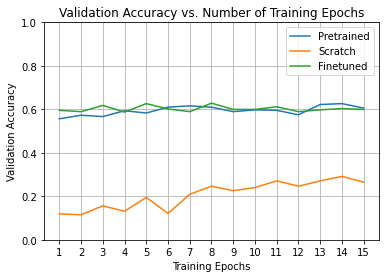

In [46]:
#Code here
ohist = []
shist = []
fhist = []

ohist = [h.cpu().numpy() for h in hist]
fhist = [h.cpu().numpy() for h in finetuned_hist]
shist = [h.cpu().numpy() for h in scratch_hist]

plt.title("Validation Accuracy vs. Number of Training Epochs")
plt.xlabel("Training Epochs")
plt.ylabel("Validation Accuracy")
plt.plot(range(1,num_epochs+1),ohist,label="Pretrained")
plt.plot(range(1,num_epochs+1),shist,label="Scratch")
plt.plot(range(1,num_epochs+1),fhist,label="Finetuned")
plt.ylim((0,1.))
plt.grid(True)
plt.xticks(np.arange(1, num_epochs+1, 1.0))
plt.legend()
plt.show()

Question: Which of the three trained models performed best in terms of validation accuracy?
Explain why.

Answer: both the pretrained and finetuned models perform very similarly in terms of validation accuracy. This is because they already have a large amount of trained parameters (weights) and hence need less learning to achieve better results, rather just need to be tweaked for the new marvel dataset that we have provided to them. The scratch model will need to be trained over a large number of epochs before it achieves results similar to the other 2 models